## Setup a classification experiment

In [11]:
import pandas as pd
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt

## Params

In [2]:
# Open JSON paramerters file
with open('./config/params.json') as f:
    params = json.load(f)

# Parameters variables
COLOR_SPACE = params['color_space']

# Spatial binning parameters
EXTRACT_SPATIAL_FEATURES = params['spatial_features_settings']['extract_spatial_features']
SPATIAL_SIZE = tuple(params['spatial_features_settings']['spatial_size'])

# Color histogram parameters
EXTRACT_COLOR_FEATURES = params['color_features_settings']['extract_color_features']
COLOR_HISTOGRAM_BINS = params['color_features_settings']['color_histogram_bins']
COLOR_HISTOGRAM_RANGE = tuple(params['color_features_settings']['color_histogram_range'])

# HoG parameters
EXTRACT_HOG_FEATURES = params['hog_features_settings']['extract_hog_features']
HOG_ORIENTATIONS = params['hog_features_settings']['hog_orientations']
PIXELS_PER_CELL = tuple(params['hog_features_settings']['pixels_per_cell'])
CELLS_PER_BLOCK = tuple(params['hog_features_settings']['cells_per_block'])
HOG_CHANNEL_TO_EXTRACT = params['hog_features_settings']['hog_channel_to_extract']

PATH_TO_CSV = params["paths"]["path_to_csv"]
PATH_TO_FRAMES = params["paths"]["path_to_frames"]
PATH_TO_VIDEOS = params["paths"]["path_to_videos"]

# Model params variables
TEST_SIZE = params['test_size']
CLASSIFIER = params['classifier'] # "LinearSVC", "SVC", "RandomForestClassifier", "AdaBoost", "XGBoost", "GradientBoosting","PCA"
FILENAME_datasets = params['file_names']['datasets']
FILENAME_vehicle_features = params['file_names']['vehicle_features']
FILENAME_non_vehicle_features = params['file_names']['non_vehicle_features']
PATH_TO_MODELS  = params["paths"]['path_to_models']

## Import features

In [3]:
# Load train & test datasets
with open('./models/' + FILENAME_datasets + '.pkl', mode='rb') as f:
    data = pickle.load(f)
    print(f"{FILENAME_datasets} loaded!")

X_train = data['X_train']
y_train = data['y_train']

X_test = data['X_test']
y_test = data['y_test']

train_test_datasets loaded!


/Users/nicolas/opt/anaconda3/envs/centrale_xai/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Import model

In [6]:
# Load classifier and parameters
with open(PATH_TO_MODELS + CLASSIFIER + '.pkl', mode='rb') as f:
    data = pickle.load(f)
    print(f"{CLASSIFIER} classifier loaded!")
    
blackbox_model = data['model']
scaler = data['scaler']

LinearSVC classifier loaded!


## Show blackbox model performance

In [8]:
from interpret import show
from interpret.perf import ROC

blackbox_perf = ROC(blackbox_model.predict).explain_perf(X_test, y_test, name='Blackbox')
show(blackbox_perf)

<!-- http://127.0.0.1:7001/140302702823168/ -->

## LIME Tabular

In [9]:
from interpret.blackbox import LimeTabular
from interpret import show

#Blackbox explainers need a predict function, and optionally a dataset
lime = LimeTabular(predict_fn=blackbox_model.predict, data=X_train, random_state=1)

#Pick the instances to explain, optionally pass in labels if you have them
lime_local = lime.explain_local(X_test[:5], y_test[:5], name='LIME')

show(lime_local)

<!-- http://127.0.0.1:7001/140303659385904/ -->

## LIMEImage Explainer

Number of misclassified images =  125


TypeError: Invalid shape (6912,) for image data

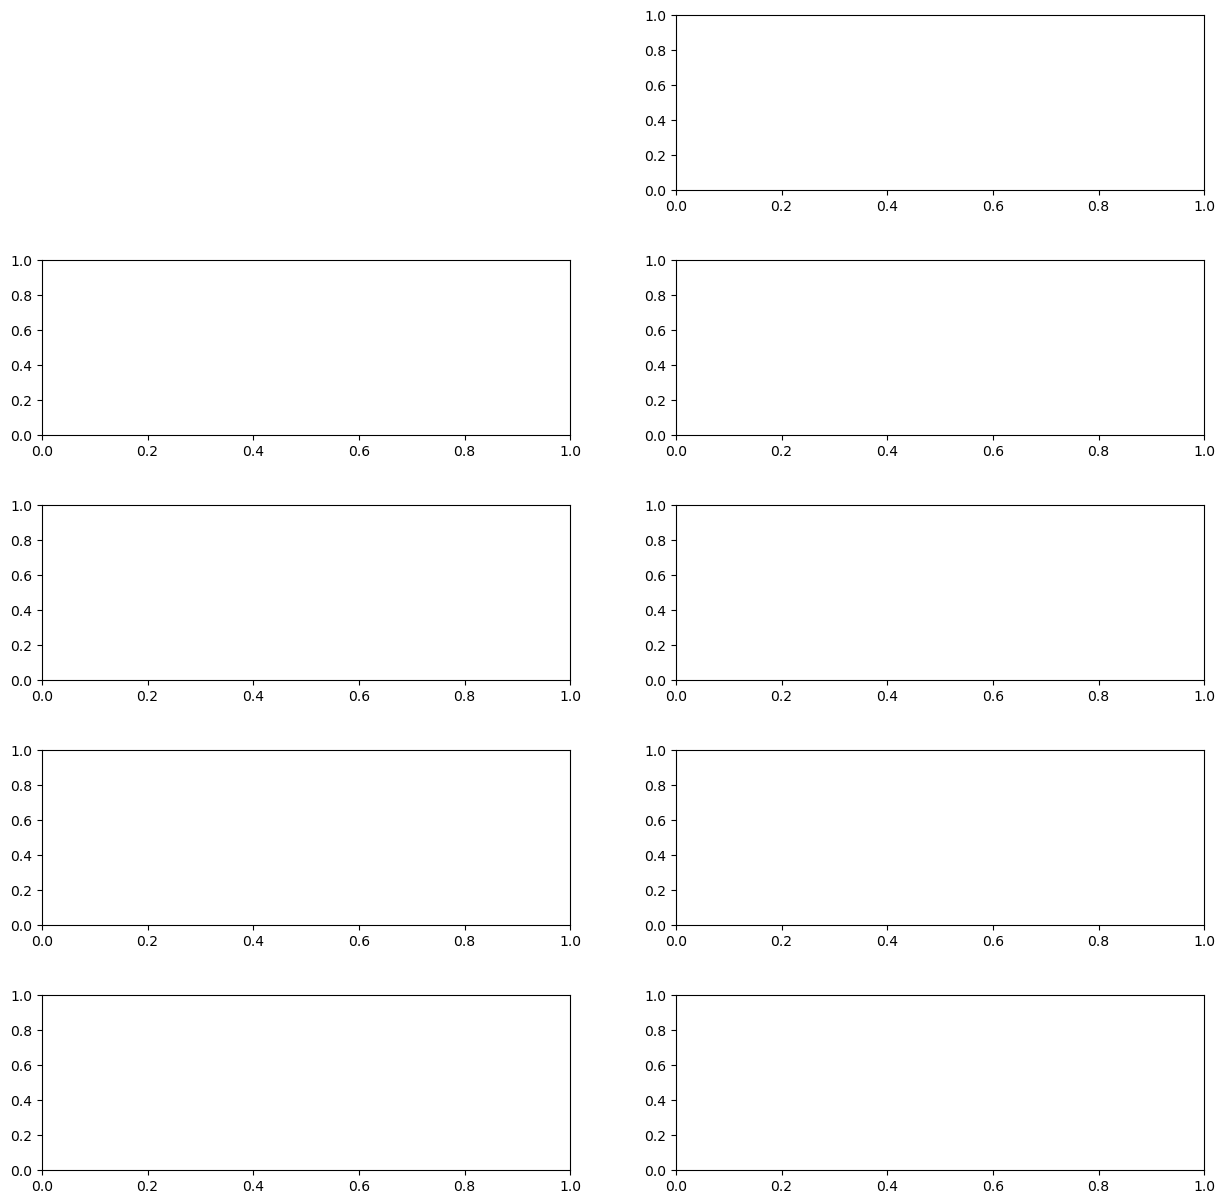

In [12]:
# Predict test set
y_pred = blackbox_model.predict(X_test)

# Check misclassified images
misclassified = np.where(y_pred != y_test)[0]
print("Number of misclassified images = ", len(misclassified))

# Plot misclassified images
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
fig.subplots_adjust(hspace = .4, wspace=.2)

ax = ax.ravel()

for i, index in enumerate(misclassified[:5]):
    image = X_test[index]
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_title(f"Predicted: {y_pred[index]}, Actual: {y_test[index]}")

plt.show()